In [ ]:
# conda env: python3
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
def areaFit(techNode):
	# R^2 = 0.9992
    return 1e-4 * techNode**3 - 0.0123 * techNode**2 + 0.881 * techNode - 7.325
def EnergyFit(techNode):
	# R^2 = 0.9999
	assert techNode <= 45
	return 0.0002 * techNode**3 - 0.009 * techNode**2 + 0.1386 * techNode - 0.5124
def LatencyFit(techNode):
    # R² = 0.9996
	return 8e-6 * techNode**4 - 0.0021 * techNode**3 + 0.2212 * techNode**2 - 5.2355 * techNode + 41.405
def PowerFit(techNode):
    # R² = 0.9992
	assert techNode <= 45
	return 0.007 * techNode**4 - 0.5274 * techNode**3 + 15.391 * techNode**2 - 149.43 * techNode + 1234.3

    
def techNodeScale(startNode: int, endNote: int):
    """
    Calculates the scaling factors for area, energy, latency, and power between two given nodes.

    Parameters:
    startNode (int): The starting node.
    endNote (int): The ending node.

    Returns:
    Tuple[float]: A tuple containing the scaling factors for area, energy, latency, and power.
    """
    s_area = areaFit(startNode)
    e_area = areaFit(endNote)
    s_energy = EnergyFit(startNode)
    e_energy = EnergyFit(endNote)
    s_latency = LatencyFit(startNode)
    e_latency = LatencyFit(endNote)
    s_power = PowerFit(startNode)
    e_power = PowerFit(endNote)
    return e_area/s_area, e_energy/s_energy, e_latency/s_latency, e_power/s_power

In [ ]:
start_node = 20
target_node = 28
area_factor, energy_factor, latency_factor, power_factor = techNodeScale(start_node, target_node)
print(f"Scaling from {start_node} to {target_node}:\narea_factor={area_factor}\nenergy_factor={energy_factor}\nlatency_factor={latency_factor}\npower_factor={power_factor}")

Scaling from 20 to 28:
area_factor=1.602429149797571
energy_factor=2.7072419106317382
latency_factor=2.80164142931124
power_factor=1.4137011282523602


In [ ]:
def extract_dense_ratio(fname):
    """
    Extracts the dense ratio values from a file and plots them in a box plot.

    Parameters:
    fname (str): The path to the file containing the dense ratio values.

    Returns:
    list: A list of tuples containing the layer number and dense ratio values.

    Example:
    >>> extract_dense_ratio('/path/to/file.txt')
    [('1', '10.5'), ('2', '15.2'), ('3', '12.8')]
    """
    dense_pt = re.compile(r'Average\(denseRatio\) of layer (\d+) = (\d+\.\d+) %')
    denseRatioList = []
    with open(fname, 'r') as f:
        content = f.read()
        denseRatioList = dense_pt.findall(content)

    denseRatioDict = {}
    for layer, ratio in denseRatioList:
        layer = int(layer)
        ratio = float(ratio)
        if layer in denseRatioDict:
            denseRatioDict[layer].append(ratio)
        else:
            denseRatioDict[layer] = [ratio]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.boxplot(denseRatioDict.values())
    ax.set_xticklabels(denseRatioDict.keys())
    plt.xlabel('Layer')
    plt.ylabel('Dense Ratio (%)')
    return denseRatioList

def extract_layer_perf(fname, key):
    if 'Latency' in key:
        info_pt  = re.compile(rf'TS (\d+) layer (\d+) {key}: (\d+\.\d+) (\S+)')
    elif 'Energy' in key:
        info_pt  = re.compile(rf'TS (\d+) layer (\d+) {key}: (\d+\.\d+e\+\d+) (\S+)')
    else:
        raise ValueError(f'Unsupported key: {key}')
        
    infoList = []
    with open(fname, 'r') as f:
        content = f.read()
        infoList = info_pt.findall(content)
    # print(len(infoList))
    # print(infoList)
    infoDict = {}
    for ts, layer, value, unit in infoList:
        ts = int(ts)
        layer = int(layer)
        value = float(value)
        if layer in infoDict:
            infoDict[layer] += value
        else:
            infoDict[layer] = value
    return infoDict
def extract_layer_info(fname):
	# FIXME: 这边只是统计了每一层的不同TS的denseRatio分布，实际上可以通过原始的output文件统计每一层的denseRatio的分布（不同crossbar）
	dense_ratio = extract_dense_ratio(fname)

	latency_key_list = ["readLatency", "bufferLatency", "icLatency", "coreLatencyADC", "coreLatencyAccum", "coreLatencyOther"]
	energy_key_list = ["readDynamicEnergy", "bufferDynamicEnergy", "icDynamicEnergy", "coreEnergyADC", "coreEnergyAccum", "coreEnergyOther"]

	fig, ax = plt.subplots(figsize=(8, 4))
	for key in latency_key_list:
		infoDict = extract_layer_perf(fname, key)
		ax.plot(infoDict.keys(), infoDict.values(), 'o-', label=key)
	plt.xlabel('Layer')
	plt.ylabel('Latency')
	plt.legend()

	fig, ax = plt.subplots(figsize=(8, 4))
	for key in energy_key_list:
		infoDict = extract_layer_perf(fname, key)
		ax.plot(infoDict.keys(), infoDict.values(), 'o-', label=key)
	plt.xlabel('Layer')
	plt.ylabel('Energy')
	# plt.yscale('log')
	plt.legend()

def extract_summary_info(fname):
    info_dict = []
    with open(fname, 'r') as f:
        content = f.read()
        for key in areaKey_um2 + latKey_ns + engKey_pJ + perfKey:
            pat1 = re.compile(rf"{key}.*?(\d+\.\d+e\+\d+)")
            pat2 = re.compile(rf"{key}.*?(\d+\.\d)")
            res1 = pat1.findall(content)
            res2 = pat2.findall(content)
            if len(res1):
                info_dict.append(res1[0])
            elif len(res2):
                info_dict.append(res2[0])
            else:
                info_dict.append('0')
    return info_dict

## Layer Performance Visualization

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

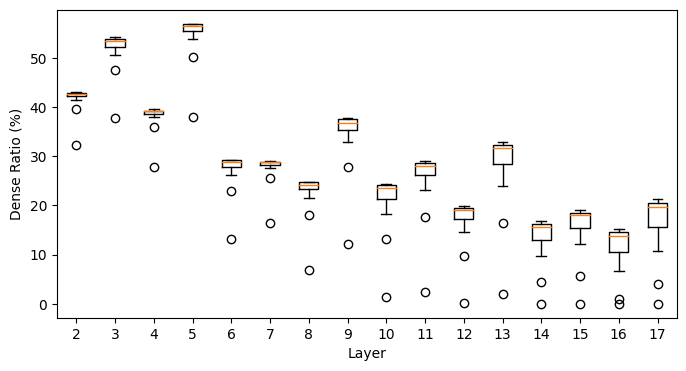

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

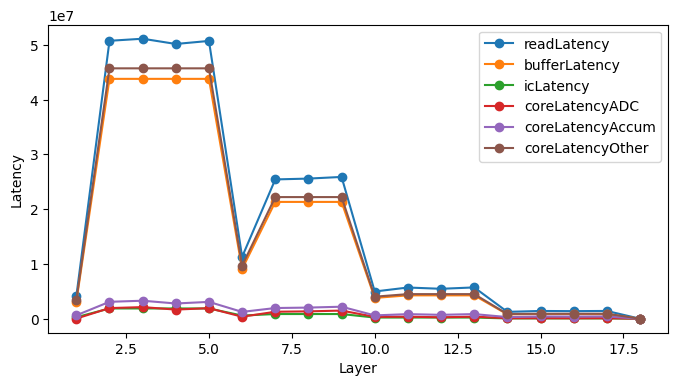

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

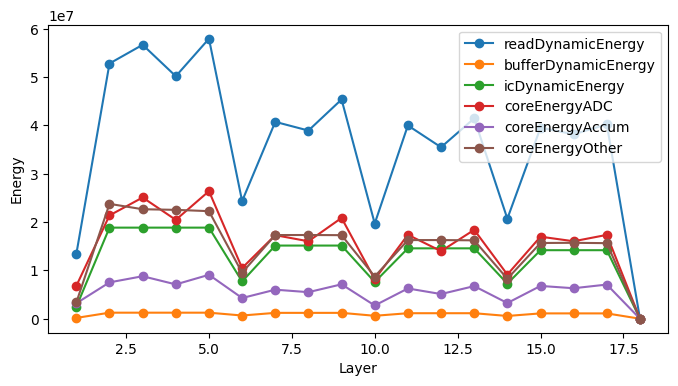

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

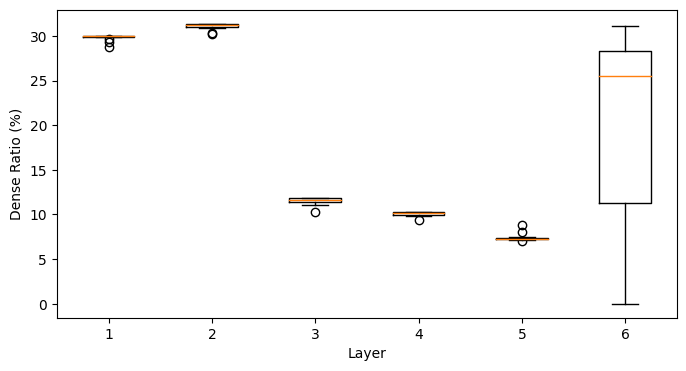

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

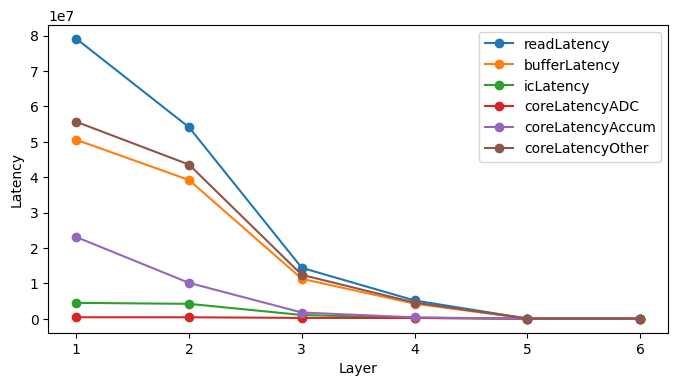

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

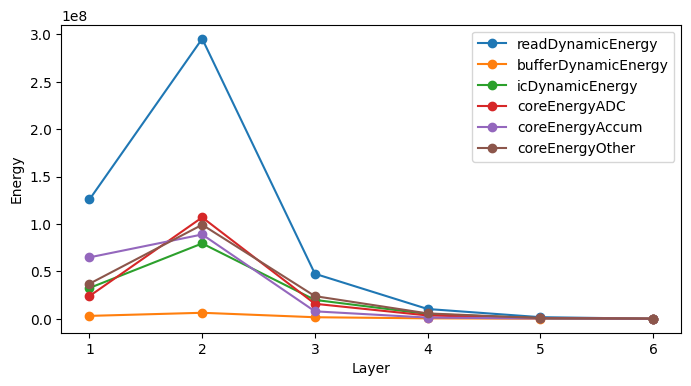

In [ ]:
fname = "../err_logs/PyNeuroSim_7_IMAGENET_column.err"
extract_layer_info(fname)
fname = "../err_logs/PyNeuroSim_7_CIFAR10DVS_column.err"
extract_layer_info(fname)
# fname = "../err_logs/PyNeuroSim_7_DVS128Gesture_column.err"
# extract_layer_info(fname)

In [ ]:
areaKey_um2 = ["Chip Area", "Chip ADC.*?Area", "Chip IC Area", "Chip Accum.*?Area", "Chip Other.*?Area", "Chip Popcnt Area", "Chip Array Area"]
latKey_ns = ["Pipelined Clock Latency", "Buffer Latency", "IC Latency", "Core Latency ADC", "Core Latency Accum", "Core Latency Other"]
engKey_pJ = ["Total Read Dynamic Energy", "Total Buffer Dynamic Energy", "Total IC Dynamic Energy", "Total Core Energy ADC", "Total Core Energy Accum", "Total Core Energy Other", "Total Core Energy Popcnt", "Total Leakage Energy"]
perfKey = ["Energy Efficiency TOPS/W", "Throughput TOPS", "Throughput FPS", "Compute Efficiency TOPS/mm\^2"]

In [26]:
import platform


fdir = "../err_logs/"
summary_fname = "perf_summary.csv"
if not os.path.exists(summary_fname):
    with open(summary_fname, 'a') as fw:
        all_keys = areaKey_um2 + latKey_ns + engKey_pJ + perfKey
        if platform.system() == 'Windows':
            fw.write('dataset,mode,TW,' + ','.join(all_keys).replace(".*?", " ", -1).replace('\\', '', -1) + '\n')
        elif platform.system() == 'Linux':
            fw.write('dataset,mode,TW,' + ','.join(all_keys).replace(".*?", " ", -1).replace('/', '', -1) + '\n')
        for fname in os.listdir(fdir):
            # extract_layer_info(fname)
            TW, dataset, mode = re.split("_|\.", fname)[1:4]
            info_dict = extract_summary_info(fdir + fname)
            fw.write(f'{dataset},{mode},{TW},' + ','.join(info_dict) + '\n')

In [27]:
def dataLoader(fname='perf_summary.csv'):
	# Load the CSV file
	data = pd.read_csv(fname)
	data.sort_values(by="TW", ascending=True, inplace=True)

	data.head()
	data["Chip Area"] -= ((127 / 128) * data["Chip Popcnt Area"])
	data["Chip Other Area"] -= data["Chip Popcnt Area"]

	data.insert(9, 'Chip Buffer Area', data["Chip Other Area"] - data["Chip IC Area"])
	data["Chip Other Area"] -= data["Chip Buffer Area"]
	data["Core Latency Other"] -= data["Buffer Latency"]

	# popcnt的面积降低为1/128
	data["Chip Popcnt Area"] /= 128

	# if dataset is DVS128Gesture, then the TS=300
	data.insert(1, 'Timesteps', data['dataset'].map({'DVS128Gesture': 300, 'IMAGENET': 100, 'CIFAR10DVS': 100}))
	data.loc[data['dataset'] == 'DVS128Gesture', 'Compute Efficiency TOPS/mm^2'] /= (1e24 * 300 / data['TW'])
	data.loc[data['dataset'] == 'CIFAR10DVS', 'Compute Efficiency TOPS/mm^2'] /= (1e24 * 100 / data['TW'])
	data.loc[data['dataset'] == 'IMAGENET', 'Compute Efficiency TOPS/mm^2'] /= (1e24 * 100 / data['TW'])

	# mergedStep = math.ceil(Timesteps / TW)
	data.insert(4, 'mergedStep', np.ceil(data['Timesteps'] / data['TW']).astype(int))

	for col in data.columns:
		if 'latency' in col.lower():
			data[col] *= data['mergedStep']

	data.insert(14, 'Core Latency Array', data['mode'].map({'array': 2.038, 'column': 1.92}))

	data.rename(columns={'Chip ADC Area': 'ADC Area'}, inplace=True)
	data.rename(columns={'Chip Accum Area': 'Accum Area'}, inplace=True)
	data.rename(columns={'Chip Other Area': 'Other Area'}, inplace=True)
	data.rename(columns={'Chip Popcnt Area': 'Popcnt Area'}, inplace=True)
	data.rename(columns={'Chip Array Area': 'Array Area'}, inplace=True)
	data.rename(columns={'Chip Buffer Area': 'Buffer Area'}, inplace=True)
 
	data.rename(columns={'Core Latency Array': 'Array Latency'}, inplace=True)
	data.rename(columns={'Core Latency ADC': 'ADC Latency'}, inplace=True)
	data.rename(columns={'Core Latency Accum': 'Accum Latency'}, inplace=True)
	data.rename(columns={'Core Latency Other': 'Other Latency'}, inplace=True)

	data.rename(columns={'Total Buffer Dynamic Energy': 'Buffer Energy'}, inplace=True)
	data.rename(columns={'Total IC Dynamic Energy': 'IC Energy'}, inplace=True)
	data.rename(columns={'Total Core Energy ADC': 'ADC Energy'}, inplace=True)
	data.rename(columns={'Total Core Energy Accum': 'Accum Energy'}, inplace=True)
	data.rename(columns={'Total Core Energy Other': 'Other Energy'}, inplace=True)
	data.rename(columns={'Total Core Energy Popcnt': 'Popcnt Energy'}, inplace=True)
 

	# 检查是否所有的数据都是有效的，如果存在未运行成功的数据，那么Energy Efficiency TOPS/W应该为0
	for index, row in data.iterrows():
		# assert row["Energy Efficiency TOPS/W"] != 0, f"{row['dataset']}-{row['mode']}-{row['TW']} miss"
		if row["Energy Efficiency TOPS/W"] == 0:
			print(f"{row['dataset']}-{row['mode']}-{row['TW']} miss")
	
	# if not os.path.exists('../perf_summary_modify.csv'):
	# 	data.to_csv('../perf_summary_modify.csv', index=False)


	# Display the first few rows of the dataframe to understand its structure
	return data


In [29]:
data = dataLoader()
print(data.columns)

Index(['dataset', 'Timesteps', 'mode', 'TW', 'mergedStep', 'Chip Area',
       'ADC Area', 'Chip IC Area', 'Accum Area', 'Other Area', 'Popcnt Area',
       'Buffer Area', 'Array Area', 'Pipelined Clock Latency', 'Array Latency',
       'Buffer Latency', 'IC Latency', 'ADC Latency', 'Accum Latency',
       'Other Latency', 'Total Read Dynamic Energy', 'Buffer Energy',
       'IC Energy', 'ADC Energy', 'Accum Energy', 'Other Energy',
       'Popcnt Energy', 'Total Leakage Energy', 'Energy Efficiency TOPS/W',
       'Throughput TOPS', 'Throughput FPS', 'Compute Efficiency TOPS/mm^2'],
      dtype='object')


In [31]:
# Identifying unique TWs, modes, and datasets
unique_TW = data['TW'].unique()
unique_modes = data['mode'].unique()
unique_datasets = data['dataset'].unique()
performance_parameters = data.columns[5:]  # Excluding the first three columns which are not performance metrics

(unique_TW, unique_modes, unique_datasets, performance_parameters.tolist())

(array([ 3,  7, 10, 15, 23, 31, 47, 63]),
 array(['array', 'column'], dtype=object),
 array(['CIFAR10DVS', 'DVS128Gesture', 'IMAGENET'], dtype=object),
 ['Chip Area',
  'ADC Area',
  'Chip IC Area',
  'Accum Area',
  'Other Area',
  'Popcnt Area',
  'Buffer Area',
  'Array Area',
  'Pipelined Clock Latency',
  'Array Latency',
  'Buffer Latency',
  'IC Latency',
  'ADC Latency',
  'Accum Latency',
  'Other Latency',
  'Total Read Dynamic Energy',
  'Buffer Energy',
  'IC Energy',
  'ADC Energy',
  'Accum Energy',
  'Other Energy',
  'Popcnt Energy',
  'Total Leakage Energy',
  'Energy Efficiency TOPS/W',
  'Throughput TOPS',
  'Throughput FPS',
  'Compute Efficiency TOPS/mm^2'])

## 绘制不同dataset的area, latency, energy的bar plot

In [32]:
def plot_mode_diff(stack_factor):
    ## ============ TW=1, mode=array ============
    cifar10dvs_groups_1a = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'array') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    dvs128gesture_groups_1a = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'array') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    imagenet_groups_1a = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'array') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    ## ============ TW=1, mode=column ============
    # cifar10dvs_groups_1c = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'column') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    # dvs128gesture_groups_1c = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'column') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    # imagenet_groups_1c = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'column') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    ## ============ TW=7, mode=array ============
    cifar10dvs_groups_7a = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'array') & (data['TW'] == 7)][item].values[0] for item in stack_factor]
    dvs128gesture_groups_7a = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'array') & (data['TW'] == 7)][item].values[0] for item in stack_factor]
    imagenet_groups_7a = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'array') & (data['TW'] == 7)][item].values[0] for item in stack_factor]
    ## ============ TW=1, mode=column ============
    cifar10dvs_groups_7c = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'column') & (data['TW'] == 7)][item].values[0] for item in stack_factor]
    dvs128gesture_groups_7c = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'column') & (data['TW'] == 7)][item].values[0] for item in stack_factor]
    imagenet_groups_7c = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'column') & (data['TW'] == 7)][item].values[0] for item in stack_factor]

    cifar10dvs_groups = np.array([cifar10dvs_groups_1a, cifar10dvs_groups_7a, cifar10dvs_groups_7c]).T
    dvs128gesture_groups = np.array([dvs128gesture_groups_1a, dvs128gesture_groups_7a, dvs128gesture_groups_7c]).T
    imagenet_groups = np.array([imagenet_groups_1a, imagenet_groups_7a, imagenet_groups_7c]).T

    plot_data = np.array([cifar10dvs_groups, dvs128gesture_groups, imagenet_groups]).transpose(2, 1, 0)	# mode, sub-area, dataset
    # print(plot_data.shape)

    bar_width = 0.2
    modes_num = plot_data.shape[0]	# 每个group分为4中mode
    sub_plot_num = plot_data.shape[1]	# 每个group分为7种sub-area
    index = np.arange(plot_data.shape[2])		# goups的数量等于dataset的数量3

    mode_index = []
    mode_index.append(index - 1.2 * bar_width)
    mode_index.append(index)
    mode_index.append(index + 1.2 * bar_width)
    print(f"{mode_index}")

    color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]
    fig, ax = plt.subplots(figsize=(8, 5))
    for i in range(modes_num):
        bottom = np.zeros(plot_data.shape[2])
        for j in range(sub_plot_num):
            if 'adc' in stack_factor[j].lower():
                color = color_bar2[0]
            elif 'accum' in stack_factor[j].lower():
                color = color_bar2[1]
            elif 'other' in stack_factor[j].lower():
                color = color_bar2[2]
            elif 'buffer' in stack_factor[j].lower():
                color = color_bar2[3]
            elif 'popcnt' in stack_factor[j].lower():
                color = color_bar2[4]
            elif 'array' in stack_factor[j].lower():
                color = color_bar2[5]
            # elif 'ic' in stack_factor[j].lower():
            #     color = color_bar2[6]
            if i == 0:
                
                plt.bar(mode_index[i], plot_data[i][j], bar_width, bottom=bottom, label=f'{stack_factor[j]}', color=color, edgecolor='black')
            else:
                plt.bar(mode_index[i], plot_data[i][j], bar_width, bottom=bottom, color=color, edgecolor='black')
            bottom += plot_data[i][j]
        # plt.xticks(mode_index[i], ["mode1", "mode2", "mode3", mode4])
                
    # plt.legend()
    plt.legend(fontsize=12, ncol=2, handleheight=2.4, labelspacing=0.25)
    plt.xticks(list(np.array(mode_index).T.flatten()), ["Baseline", "Time Batch", "LowPASS"] * modes_num, rotation=45)
    dataset_names = ["CIFAR10DVS", "DVS128Gesture", "IMAGENET"]
    for i, dataset_name in enumerate(dataset_names):
        plt.annotate(dataset_name, (index[i], 0), textcoords="offset points", xytext=(0, -70), ha='center')
    if 'area' in stack_factor[0].lower():
        plt.ylabel('Area (um^2)')
    elif 'latency' in stack_factor[0].lower():
        plt.ylabel('Latency (ns)')
    elif 'energy' in stack_factor[0].lower():
        plt.ylabel('Energy (pJ)')

def plot_mode_diff_norm(stack_factor):
    base_TW = 3
    cifar10_dvs_baseline = np.sum([data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'array') & (data['TW'] == base_TW)][item].values[0] for item in stack_factor])
    # FIXME: 这边的baseline应该是mode=array, TW=1的数据，但是暂时结果还没出，用mode=column, TW=3的数据代替
    dvs128gesture_baseline = np.sum([data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'array') & (data['TW'] == base_TW)][item].values[0] for item in stack_factor])
    imagenet_baseline = np.sum([data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'array') & (data['TW'] == base_TW)][item].values[0] for item in stack_factor])
    ## ============ TW=1, mode=array ============
    cifar10dvs_groups_1a = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'array') & (data['TW'] == base_TW)][item].values[0] for item in stack_factor] / cifar10_dvs_baseline
    # FIXME: 这边的baseline应该是mode=array, TW=1的数据，但是暂时结果还没出，用mode=column, TW=3的数据代替
    dvs128gesture_groups_1a = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'array') & (data['TW'] == base_TW)][item].values[0] for item in stack_factor] / dvs128gesture_baseline
    imagenet_groups_1a = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'array') & (data['TW'] == base_TW)][item].values[0] for item in stack_factor] / imagenet_baseline
    ## ============ TW=1, mode=column ============
    # cifar10dvs_groups_1c = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'column') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    # dvs128gesture_groups_1c = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'column') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    # imagenet_groups_1c = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'column') & (data['TW'] == 1)][item].values[0] for item in stack_factor]
    ## ============ TW=7, mode=array ============
    cifar10dvs_groups_7a = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'array') & (data['TW'] == 7)][item].values[0] for item in stack_factor] / cifar10_dvs_baseline
    dvs128gesture_groups_7a = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'array') & (data['TW'] == 7)][item].values[0] for item in stack_factor] / dvs128gesture_baseline
    imagenet_groups_7a = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'array') & (data['TW'] == 7)][item].values[0] for item in stack_factor] / imagenet_baseline
    ## ============ TW=1, mode=column ============
    cifar10dvs_groups_7c = [data[(data['dataset'] == 'CIFAR10DVS') & (data['mode'] == 'column') & (data['TW'] == 7)][item].values[0] for item in stack_factor] / cifar10_dvs_baseline
    dvs128gesture_groups_7c = [data[(data['dataset'] == 'DVS128Gesture') & (data['mode'] == 'column') & (data['TW'] == 7)][item].values[0] for item in stack_factor] / dvs128gesture_baseline
    imagenet_groups_7c = [data[(data['dataset'] == 'IMAGENET') & (data['mode'] == 'column') & (data['TW'] == 7)][item].values[0] for item in stack_factor] / imagenet_baseline

    cifar10dvs_groups = np.array([cifar10dvs_groups_1a, cifar10dvs_groups_7a, cifar10dvs_groups_7c]).T
    dvs128gesture_groups = np.array([dvs128gesture_groups_1a, dvs128gesture_groups_7a, dvs128gesture_groups_7c]).T
    imagenet_groups = np.array([imagenet_groups_1a, imagenet_groups_7a, imagenet_groups_7c]).T

    plot_data = np.array([cifar10dvs_groups, dvs128gesture_groups, imagenet_groups]).transpose(2, 1, 0)	# mode, sub-area, dataset
    # print(plot_data.shape)

    bar_width = 0.2
    modes_num = plot_data.shape[0]	# 每个group分为4中mode
    sub_plot_num = plot_data.shape[1]	# 每个group分为7种sub-area
    index = np.arange(plot_data.shape[2])		# goups的数量等于dataset的数量3

    mode_index = []
    mode_index.append(index - 1.2 * bar_width)
    mode_index.append(index)
    mode_index.append(index + 1.2 * bar_width)
    print(f"{mode_index}")

    color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]
    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    max_bottom = {}
    for i in range(modes_num):
        max_bottom[i] = np.zeros(plot_data.shape[2])
        bottom = np.zeros(plot_data.shape[2])
        for j in range(sub_plot_num):
            if 'adc' in stack_factor[j].lower():
                color = color_bar2[0]
            elif 'accum' in stack_factor[j].lower():
                color = color_bar2[1]
            elif 'other' in stack_factor[j].lower():
                color = color_bar2[2]
            elif 'buffer' in stack_factor[j].lower():
                color = color_bar2[3]
            elif 'popcnt' in stack_factor[j].lower():
                color = color_bar2[4]
            elif 'array' in stack_factor[j].lower():
                color = color_bar2[5]
            # elif 'ic' in stack_factor[j].lower():
            #     color = color_bar2[6]
            if i == 0:
                
                plt.bar(mode_index[i], plot_data[i][j], bar_width, bottom=bottom, label=f'{" ".join([item for item in stack_factor[j].split() if item not in ["Core", "Chip", "Total", "Dynamic"]])}', color=color, edgecolor='black')
            else:
                plt.bar(mode_index[i], plot_data[i][j], bar_width, bottom=bottom, color=color, edgecolor='black')
            bottom += plot_data[i][j]
            # update max_bottom
            max_bottom[i] = [bi if bi > mi else mi for bi,mi in zip(bottom, max_bottom[i])]
        # plt.xticks(mode_index[i], ["mode1", "mode2", "mode3", mode4])
                
    # plt.legend()
    # plt.legend(fontsize=14, ncol=2, handleheight=2.4, labelspacing=0.25, loc='lower right')
    plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.50, 1.29),
                 fancybox=True, shadow=True, ncol=3, labelspacing=0.4, handleheight=1.5)
    plt.xticks(list(np.array(mode_index).T.flatten()), ["Baseline", "PIM+PTB", "LowPASS"] * modes_num, rotation=45, fontsize=14)
    # yticks 用百分比表示
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()], fontsize=14)
    # get the y-axis limits
    plt.ylim(0, max(max(max_bottom.values())) + 0.05)
    dataset_names = ["CIFAR10DVS", "DVS128Gesture", "IMAGENET"]
    for i, dataset_name in enumerate(dataset_names):
        plt.annotate(dataset_name, (index[i], 0), textcoords="offset points", xytext=(0, -75), ha='center', fontsize=14)
    if 'area' in stack_factor[0].lower():
        plt.axhline(y=max_bottom[0][1], xmin=0.45, xmax=0.62, linestyle='--', color='#a30b33')
        plt.annotate(f"{(1 - max_bottom[1][1] / max_bottom[0][1]) * 100:.2f}%\nspeedup", xy=(mode_index[0][1], max_bottom[0][1]), xytext=(mode_index[0][1] - 0.45, max_bottom[0][1]-0.05), color="#a30b33", fontsize=14)
        plt.annotate("", xy=(mode_index[0][1], max_bottom[1][1]), xytext=(mode_index[0][1], max_bottom[1][1]+0.1), color="#a30b33", arrowprops=dict(arrowstyle="->", color="#a30b33", linewidth=2))
        plt.annotate("", xy=(mode_index[0][1], max_bottom[0][1]), xytext=(mode_index[0][1], max_bottom[0][1]-0.1), color="#a30b33", arrowprops=dict(arrowstyle="->", color="#a30b33", linewidth=2))

        plt.axhline(y=max_bottom[1][1], xmin=0.38, xmax=0.5, linestyle='--', color='#a30b33')
        plt.annotate("", xy=(mode_index[2][1], max_bottom[2][1]), xytext=(mode_index[2][1], max_bottom[0][1]), color="#a30b33", arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
        plt.annotate(f"{(max_bottom[0][1] / max_bottom[2][1]):.2f}x\nspeedup", xy=(mode_index[2][1], max_bottom[2][1]), xytext=(mode_index[2][1] + 0.05, max_bottom[0][1] - 0.15), color="#a30b33", fontsize=14)
        

        plt.ylabel('Normalized Area', fontsize=14)
        plt.savefig('area_brk.pdf', dpi=300, bbox_inches='tight')
    elif 'latency' in stack_factor[0].lower():
        plt.ylabel('Normalized Latency', fontsize=14)
    elif 'energy' in stack_factor[0].lower():
        plt.axhline(y=max_bottom[0][1], xmin=0.38, xmax=0.62, linestyle='--', color='#a30b33')
        plt.axhline(y=max_bottom[1][1], xmin=0.48, xmax=0.62, linestyle='--', color='#a30b33')
        plt.annotate("", xy=(mode_index[2][1], max_bottom[2][1]), xytext=(mode_index[2][1], max_bottom[0][1]), color="#a30b33", arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
        plt.annotate(f"{(max_bottom[0][1] / max_bottom[2][1]):.2f}x\nspeedup\nw.r.t\nbaseline", xy=(mode_index[2][1]+0.05, (max_bottom[2][1] + max_bottom[0][1])/2), xytext=(mode_index[2][1]+0.05, (max_bottom[2][1] + max_bottom[0][1])/2), color="#a30b33", fontsize=14)

        plt.annotate("", xy=(mode_index[2][1], max_bottom[2][1]), xytext=(mode_index[2][1], max_bottom[1][1]), color="#a30b33", arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
        plt.annotate(f"{(max_bottom[1][1] / max_bottom[2][1]):.2f}x\nspeedup\nw.r.t\nbaseline", xy=(mode_index[2][1]+0.12, (max_bottom[2][1] + max_bottom[1][1])/2), xytext=(mode_index[2][1]+0.12, (max_bottom[2][1] + max_bottom[1][1])/2-0.1), color="#a30b33", fontsize=14)
        
        plt.ylabel('Normalized Energy', fontsize=14)
        plt.savefig('energy_brk.pdf', dpi=300, bbox_inches='tight')


[array([-0.24,  0.76,  1.76]), array([0, 1, 2]), array([0.24, 1.24, 2.24])]


/tmp/ipykernel_1689682/1496768144.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()], fontsize=14)
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Gen

[array([-0.24,  0.76,  1.76]), array([0, 1, 2]), array([0.24, 1.24, 2.24])]


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

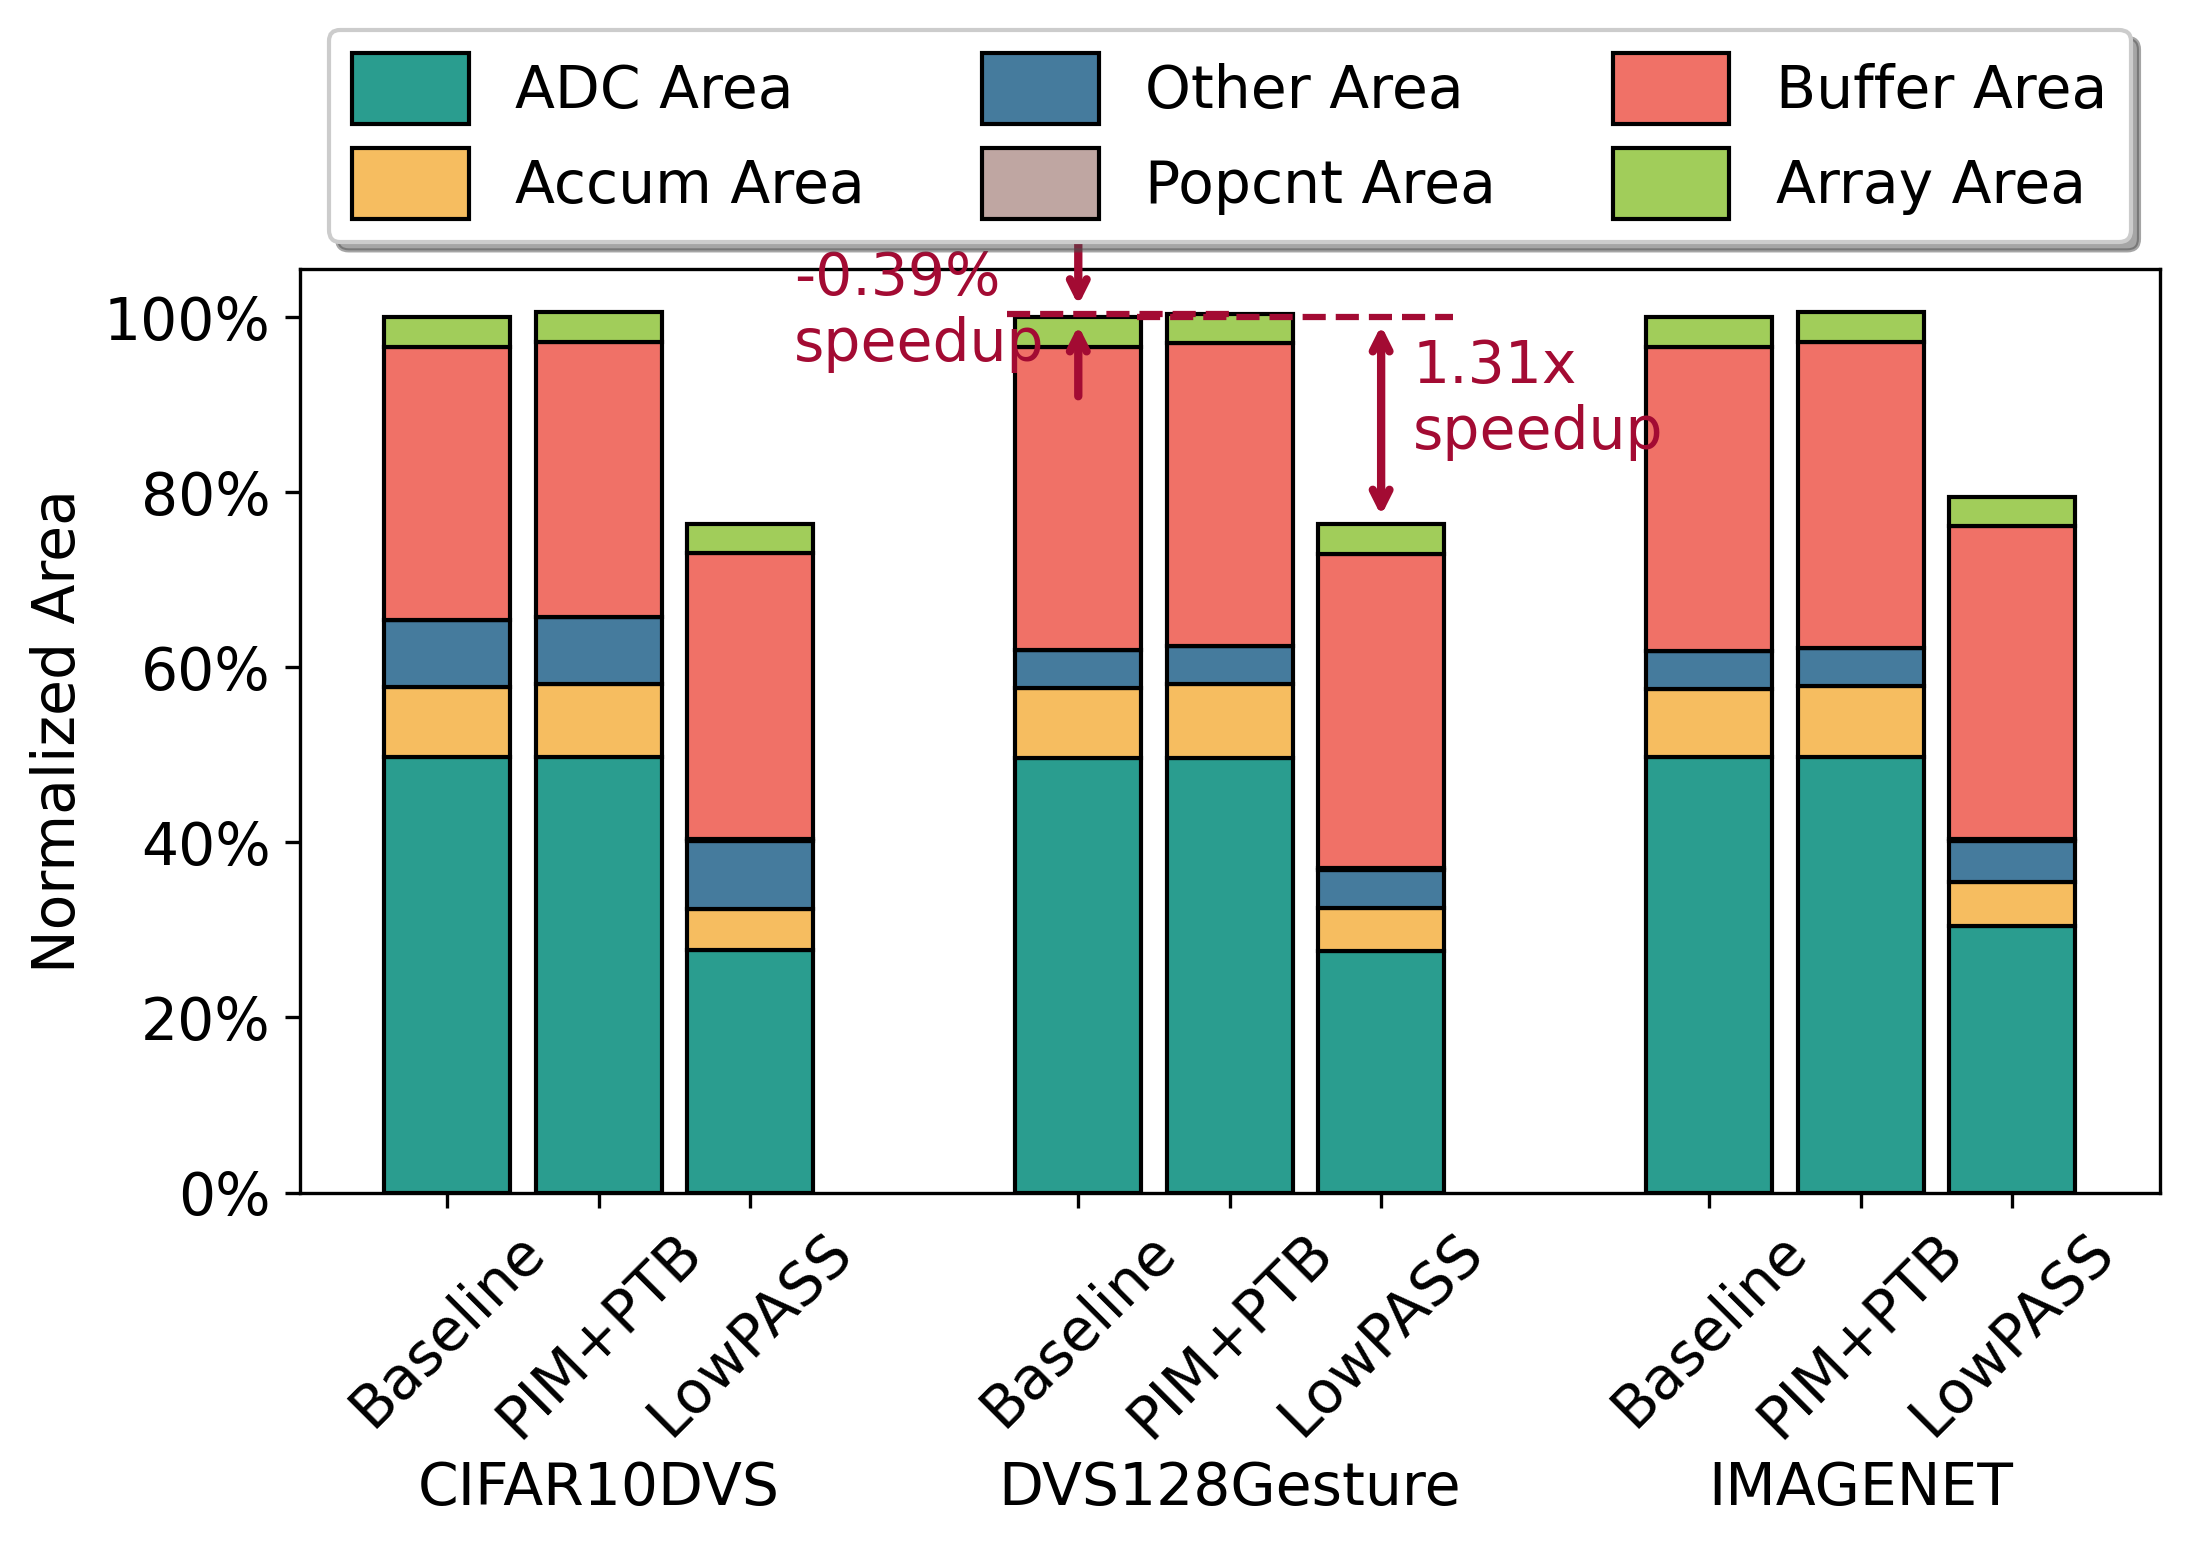

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

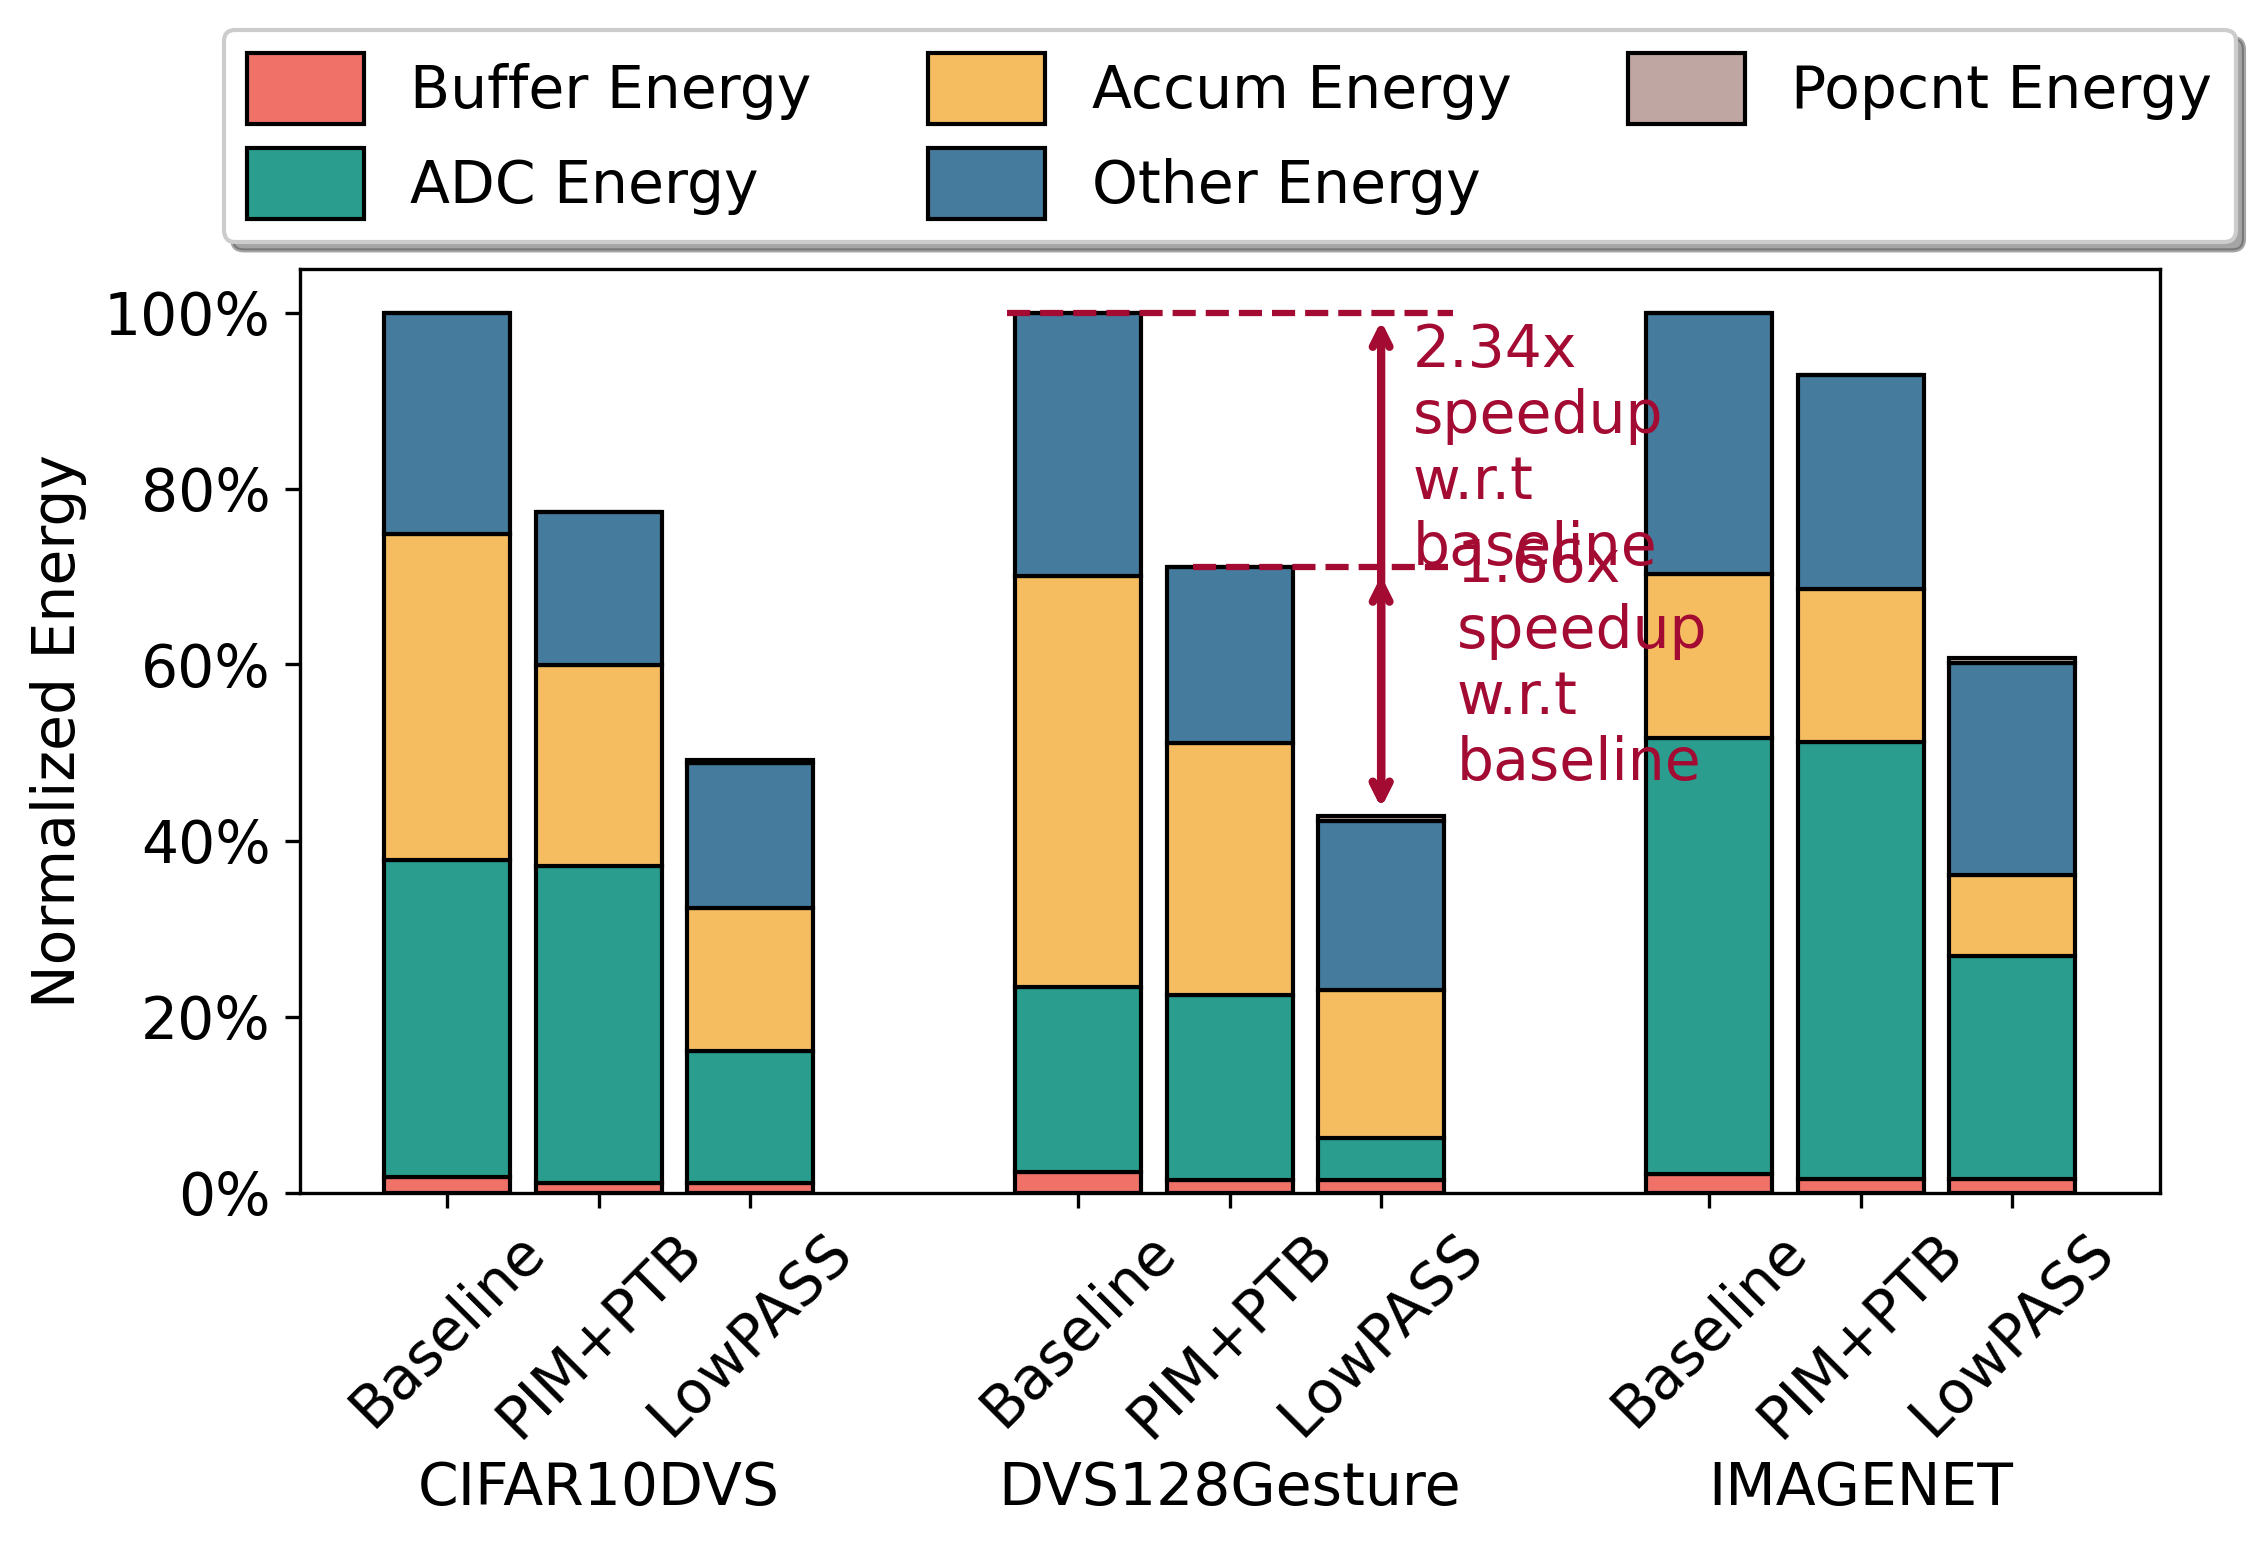

In [33]:

# ============ Area ============
stack_factor = ['ADC Area', 'Accum Area', 'Other Area', 'Popcnt Area', 'Buffer Area', 'Array Area']
plot_mode_diff_norm(stack_factor)
# stack_factor = ['Array Latency', 'Buffer Latency', 'ADC Latency', 'Accum Latency', 'Other Latency']
# plot_mode_diff_norm(stack_factor)
stack_factor = ['Buffer Energy', 'ADC Energy', 'Accum Energy', 'Other Energy', 'Popcnt Energy']
plot_mode_diff_norm(stack_factor)

## 绘制throughput/W

In [34]:
data.columns

Index(['dataset', 'Timesteps', 'mode', 'TW', 'mergedStep', 'Chip Area',
       'ADC Area', 'Chip IC Area', 'Accum Area', 'Other Area', 'Popcnt Area',
       'Buffer Area', 'Array Area', 'Pipelined Clock Latency', 'Array Latency',
       'Buffer Latency', 'IC Latency', 'ADC Latency', 'Accum Latency',
       'Other Latency', 'Total Read Dynamic Energy', 'Buffer Energy',
       'IC Energy', 'ADC Energy', 'Accum Energy', 'Other Energy',
       'Popcnt Energy', 'Total Leakage Energy', 'Energy Efficiency TOPS/W',
       'Throughput TOPS', 'Throughput FPS', 'Compute Efficiency TOPS/mm^2'],
      dtype='object')

In [35]:
datasets = ['CIFAR10DVS', 'DVS128Gesture', 'IMAGENET']
# data sort with dataset
sorted_datas = data.sort_values('dataset')
mode0_data = [data[(data['TW'] == 1) & (data['mode'] == 'array') & (data['dataset'] == item)]['Energy Efficiency TOPS/W'].values[0] for item in datasets]
mode1_data = [data[(data['TW'] == 7) & (data['mode'] == 'array') & (data['dataset'] == item)]['Energy Efficiency TOPS/W'].values[0] for item in datasets]
mode2_data = [data[(data['TW'] == 7) & (data['mode'] == 'column') & (data['dataset'] == item)]['Energy Efficiency TOPS/W'].values[0] for item in datasets]
print(mode0_data, mode1_data, mode2_data)
print(f"{np.array(mode1_data) / np.array(mode0_data)}, {np.array(mode2_data) / np.array(mode0_data)}")
print(f"{np.array(mode2_data) / np.array(mode1_data)}")
color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]

bar_width = 0.2
mode_index0 = np.arange(len(datasets)) - 0.25
mode_index1 = np.arange(len(datasets))
mode_index2 = np.arange(len(datasets)) + 0.25
bottom = np.zeros_like(mode1_data)
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
plt.bar(mode_index0, mode0_data, bar_width, bottom=bottom, color=color_bar2[0], edgecolor='black', label='Baseline')
plt.bar(mode_index1, mode1_data, bar_width, bottom=bottom, color=color_bar2[1], edgecolor='black', label='PIM+PTB')
plt.bar(mode_index2, mode2_data, bar_width, bottom=bottom, color=color_bar2[2], edgecolor='black', label='LowPASS')
plt.xticks(mode_index1, datasets, fontsize=14) 
plt.ylabel('Throughtput Efficiency(TOPS/W)', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, handleheight=1.5)
# plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.50, 1.25),
#                 fancybox=True, shadow=True, ncol=3, labelspacing=0.4, handleheight=1.5)
# ax.axline((0, 0), (1, 1))

ax.axhline(y=mode2_data[1], xmin=0.38, xmax=0.69, linestyle='--', color='#a30b33')
ax.annotate("", xy=(mode_index0[1], mode2_data[1]), xytext=(mode_index0[1], mode0_data[1]),
            arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))

ax.annotate(f"{mode2_data[1]/mode0_data[1]:.2f}x\nspeedup\nw.r.t\nbaseline", xy=(mode_index0[1] + 0.05, (mode2_data[1] + mode0_data[1])/2), xytext=(mode_index0[1] + 0.05, (mode2_data[1] + mode0_data[1])/2), color="#a30b33", fontsize=14)

ax.axhline(y=mode1_data[1], xmin=0.465, xmax=0.69, linestyle='--', color='#a30b33')
ax.annotate("", xy=(mode_index1[1] + 2.3 * bar_width, mode2_data[1]), xytext=(mode_index1[1] + 2.3 * bar_width, mode1_data[1]),
            arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
ax.annotate(f"{mode2_data[1]/mode1_data[1]:.2f}x\nspeedup\nw.r.t\ntime batch", xy=(mode_index2[1] + 0.25, (mode2_data[1] + mode1_data[1])/2), xytext=(mode_index2[1] + 0.25, (mode2_data[1] + mode1_data[1])/2-80), color="#a30b33", fontsize=14)

print(mode_index1, mode_index2)
plt.savefig('tp_eff.pdf', dpi=300, bbox_inches='tight')

IndexError: index 0 is out of bounds for axis 0 with size 0

## 分割

In [152]:
from numpy import argmax


def plot_performance_trend_sorted(parameter, ax=None):

    # plt.figure(figsize=(12, 8))

    color_bar = [
        "#2a9d8f",
        "#F6BD60",
        "#457b9d",
        "#F07167",
        "#BFA6A2",
        "#A1CD5A",
        "#ED7D31",
    ]

    marker_bar = ["o", ">", "*", "+"]


    if ax == None:
        fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    for i, dataset in enumerate(unique_datasets):

        # Filtering data for the current dataset

        dataset_data = data[data["dataset"] == dataset]
        alpha = 0.7
        data_tw_3 = dataset_data.loc[(dataset_data['TW'] == 3) & (dataset_data['mode'] == 'column'), parameter].reset_index(drop=True)
        data_tw_10 = dataset_data.loc[(dataset_data['TW'] == 10) & (dataset_data['mode'] == 'column'), parameter].reset_index(drop=True)
        sliding_average = (1 - alpha) * data_tw_3 + alpha * data_tw_10
        indexes_tw_7 = dataset_data[(dataset_data['TW'] == 7) & (dataset_data['mode'] == 'column')].index
        dataset_data.loc[indexes_tw_7, parameter] = sliding_average.values


        for j, mode in enumerate(unique_modes):

            # Extracting mode-specific data and sorting by TW

            mode_data = dataset_data[dataset_data["mode"] == mode].sort_values(by="TW")


            # Plotting

            # plt.plot(mode_data['TW'], mode_data[parameter], marker=marker_bar[j], label=f'{dataset} - {mode}', color=color_bar[i], markersize=8)
            if mode == "array":

                ax.plot(
                    mode_data["TW"],
                    mode_data[parameter],
                    marker=marker_bar[j],
                    label=f"{dataset}-PIM+PTB",
                    color=color_bar[i],
                    markersize=8,
                    linestyle="--",
                )
            elif mode == "column":
                ax.plot(
                    mode_data["TW"],
                    mode_data[parameter],
                    marker=marker_bar[j],
                    label=f"{dataset}-LowPASS",
                    color=color_bar[i],
                    markersize=8,
                )

    for i, dataset in enumerate(unique_datasets):

        # Filtering data for the current dataset

        dataset_data = data[data["dataset"] == dataset]
        alpha = 0.7
        data_tw_3 = dataset_data.loc[(dataset_data['TW'] == 3) & (dataset_data['mode'] == 'column'), parameter].reset_index(drop=True)
        data_tw_10 = dataset_data.loc[(dataset_data['TW'] == 10) & (dataset_data['mode'] == 'column'), parameter].reset_index(drop=True)
        sliding_average = (1 - alpha) * data_tw_3 + alpha * data_tw_10
        indexes_tw_7 = dataset_data[(dataset_data['TW'] == 7) & (dataset_data['mode'] == 'column')].index
        dataset_data.loc[indexes_tw_7, parameter] = sliding_average.values
        alpha = 0.7
        # dataset_data.loc[dataset_data['TW'] == 7, parameter] = dataset_data.loc[dataset_data['TW'] == 10, parameter] * alpha + dataset_data.loc[dataset_data['TW'] == 3, parameter].values
        # 找到优势最明显的TW，这边用LowPASS的峰值代替
        opt_id = argmax(
            dataset_data[dataset_data["mode"] == "column"][parameter].tolist()
        )
        opt_tw = dataset_data[dataset_data["mode"] == "column"]["TW"].tolist()[opt_id]
        print(f"max_tw for {dataset} is {opt_tw}")
        opt_column_perf = dataset_data[
            (dataset_data["mode"] == "column") & (dataset_data["TW"] == opt_tw)
        ][parameter].values[0]
        opt_array_perf = dataset_data[
            (dataset_data["mode"] == "array") & (dataset_data["TW"] == opt_tw)
        ][parameter].values[0]
        plt.plot(
            opt_tw,
            opt_array_perf,
            marker="*",
            markeredgecolor="r",
            markersize=10,
            color=color_bar[i],
        )
        plt.plot(
            opt_tw,
            opt_column_perf,
            marker="*",
            markeredgecolor="r",
            markersize=10,
            color=color_bar[i],
        )
        # plt.annotate('', xy=(opt_tw, opt_column_perf), xytext=(opt_tw, opt_array_perf), )

        ax.annotate(
            "",
            xy=(opt_tw, 0.98*opt_column_perf),
            xytext=(opt_tw, 1.05*opt_array_perf),
            va="center",
            ha="center",
            arrowprops=dict(
                color="#a30b33",
                arrowstyle="<->",
                connectionstyle="arc3,rad=0.4",
                # linestyle="--",
                # linewidth=1
            ),
        )
        plt.annotate(f'{opt_column_perf/opt_array_perf:.2f}x\nspeedup', xy=(1.2*opt_tw-1, (0.7*opt_column_perf)), xytext=(1.2*opt_tw-1, (0.7*opt_column_perf)))


    lns = ax.get_lines()

    labs = [l.get_label() for l in lns]

    ax.legend(lns, labs, loc="upper right", ncol=3, fontsize=9)


    # plt.title(f'Trend of {parameter} by TW for Different Datasets and Modes (Sorted)')

    # plt.xlabel('Time Window (TW)')

    # plt.ylabel(parameter)

    # plt.legend()

    # plt.grid(True)

    # plt.xticks(sorted(unique_TW))  # Ensure all TW values are represented in sorted order

    # plt.show()


    # ax.title.set_text(f'Trend of {parameter} by TW for Different Datasets and Modes (Sorted)')

    ax.set_xlabel("Time Window")
    if parameter == "Energy Efficiency TOPS/W":
        ax.set_ylabel("Energy Efficiency (TOPS/W)")
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin=ymin, ymax=ymax + 200)
    else:
        ax.set_ylabel(parameter)

    # ax.legend()

    ax.grid(True)

    ax.set_xticks(
        sorted(unique_TW)
    )  # Ensure all TW values are represented in sorted order
    plt.savefig('tw_ee.pdf', dpi=300, bbox_inches='tight')



# Replot for "Energy Efficiency TOPS/W" with sorted TW

params = len(performance_parameters.tolist())

row = math.ceil(math.sqrt(params))

col = math.ceil(params / row)

fig, ax = plt.subplots(row, col, figsize=(25, 20))
for idx, perf in enumerate(performance_parameters.tolist()):

    plot_performance_trend_sorted(perf, ax[idx // col, idx % col])

# plot_performance_trend_sorted("Energy Efficiency TOPS/W")

d:\Anaconda3\envs\python3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


max_tw for IMAGENET is 63
max_tw for DVS128Gesture is 63
max_tw for CIFAR10DVS is 63
max_tw for IMAGENET is 1
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 1
max_tw for IMAGENET is 63
max_tw for DVS128Gesture is 63
max_tw for CIFAR10DVS is 63
max_tw for IMAGENET is 63
max_tw for DVS128Gesture is 63
max_tw for CIFAR10DVS is 63
max_tw for IMAGENET is 63
max_tw for DVS128Gesture is 63
max_tw for CIFAR10DVS is 63
max_tw for IMAGENET is 63
max_tw for DVS128Gesture is 63
max_tw for CIFAR10DVS is 63


d:\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in double_scalars


max_tw for IMAGENET is 10
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 1
max_tw for IMAGENET is 1
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 1
max_tw for IMAGENET is 1
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 1
max_tw for IMAGENET is 1
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 1
max_tw for IMAGENET is 1
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 1
max_tw for IMAGENET is 1
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 1
max_tw for IMAGENET is 1
max_tw for DVS128Gesture is 1
max_tw for CIFAR10DVS is 47


KeyboardInterrupt: 

ValueError: Image size of 1644x60413313 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x1440 with 30 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

unique_TW = sorted(data['TW'].unique())
unique_modes = data['mode'].unique()
unique_datasets = data['dataset'].unique()
performance_parameters = data.columns[3:]  # Excluding the first three columns which are not performance metrics

# (unique_TW, unique_modes, unique_datasets, performance_parameters.tolist())

filted_params = ['Chip Area', 'Total Leakage Energy', 'Energy Efficiency TOPS/W', 'Throughput TOPS', 'Throughput FPS', 'Compute Efficiency TOPS/mm^2', "Total Read Dynamic Energy"]
performance_parameters_for_stacking = list(set(performance_parameters.tolist()) - set(filted_params))

# (unique_TW, unique_modes, unique_datasets, performance_parameters_for_stacking)

baseParams = ["dataset", "mode", "Timesteps", "TW", "mergedStep"]
areaStackParam = baseParams + [item for item in performance_parameters_for_stacking if "area" in item.lower()]
latencyStackParam = baseParams + [item for item in performance_parameters_for_stacking if "latency" in item.lower()]
energyStackParam = baseParams + [item for item in performance_parameters_for_stacking if "energy" in item.lower()]
(areaStackParam, latencyStackParam, energyStackParam)

area_data = data[areaStackParam]
latency_data = data[latencyStackParam]
energy_data = data[energyStackParam]
latency_data.columns

Index(['dataset', 'mode', 'Timesteps', 'TW', 'mergedStep', 'Accum Latency',
       'Array Latency', 'Buffer Latency', 'ADC Latency', 'IC Latency',
       'Other Latency', 'Pipelined Clock Latency'],
      dtype='object')

In [ ]:
# 使用CIFAR10DVS进行堆积图分析
dataset = "CIFAR10DVS"
cifar10dvs_area_data = area_data[area_data["dataset"] == dataset]
cifar10dvs_latency_data = latency_data[latency_data["dataset"] == dataset]
cifar10dvs_energy_data = energy_data[energy_data["dataset"] == dataset]
cifar10dvs_area_data.head()
# cifar10dvs_latency_data.head()
# cifar10dvs_energy_data.head()

,dataset,mode,Timesteps,TW,mergedStep,Array Area,Other Area,Buffer Area,Accum Area,Popcnt Area,ADC Area,Chip IC Area
13,CIFAR10DVS,column,100,1,100,2020000.0,4290000.0,19790000.0,1180000.0,68906.25,16600000.0,4290000.0
12,CIFAR10DVS,array,100,1,100,2020000.0,4460000.0,18740000.0,1920000.0,0.00,29800000.0,4460000.0
30,CIFAR10DVS,array,100,3,34,2020000.0,4570000.0,18730000.0,4780000.0,0.00,29800000.0,4570000.0
31,CIFAR10DVS,column,100,3,34,2020000.0,4440000.0,19660000.0,2720000.0,85937.50,16600000.0,4440000.0
48,CIFAR10DVS,array,100,7,15,2020000.0,4580000.0,18820000.0,5000000.0,0.00,29800000.0,4580000.0


In [ ]:
color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]
# unique_TW = [str(item) for item in unique_TW]

In [ ]:
cifar10dvs_latency_data.columns

Index(['dataset', 'mode', 'Timesteps', 'TW', 'mergedStep', 'Accum Latency',
       'Array Latency', 'Buffer Latency', 'ADC Latency', 'IC Latency',
       'Other Latency', 'Pipelined Clock Latency'],
      dtype='object')

## Area堆积图

In [ ]:
# -------------------------- Area -------------------------- #
cifar10dvs_popcnt_area_data_col = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "column"]["Chip Popcnt Area"].tolist())
cifar10dvs_array_area_data_col = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "column"]["Chip Array Area"].tolist())
# ic_area are included by other area
cifar10dvs_other_area_data_col = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "column"]["Chip Other Area"].tolist())
cifar10dvs_adc_area_data_col = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "column"]["Chip ADC Area"].tolist())
cifar10dvs_accum_area_data_col = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "column"]["Chip Accum Area"].tolist())
cifar10dvs_buffer_area_data_col = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "column"]["Chip Buffer Area"].tolist())


cifar10dvs_popcnt_area_data_arr = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "array"]["Chip Popcnt Area"].tolist())
cifar10dvs_array_area_data_arr = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "array"]["Chip Array Area"].tolist())
# ic_area are included by other area
cifar10dvs_other_area_data_arr = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "array"]["Chip Other Area"].tolist())
cifar10dvs_adc_area_data_arr = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "array"]["Chip ADC Area"].tolist())
cifar10dvs_accum_area_data_arr = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "array"]["Chip Accum Area"].tolist())
cifar10dvs_buffer_area_data_arr = np.array(cifar10dvs_area_data[cifar10dvs_area_data["mode"] == "array"]["Chip Buffer Area"].tolist())

# -------------------------- Latency -------------------------- #
cifar10dvs_adc_latency_data_col = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["Core Latency ADC"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["mergedStep"].tolist())
cifar10dvs_buffer_latency_data_col = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["Buffer Latency"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["mergedStep"].tolist())
cifar10dvs_other_latency_data_col = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["Core Latency Other"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["mergedStep"].tolist())
cifar10dvs_accum_latency_data_col = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["Core Latency Accum"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["mergedStep"].tolist())
# cifar10dvs_ic_latency_data_col = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["IC Latency"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["mergedStep"].tolist())
cifar10dvs_array_latency_data_col = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["Core Latency Array"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["mergedStep"].tolist())

cifar10dvs_adc_latency_data_arr = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["Core Latency ADC"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["mergedStep"].tolist())
cifar10dvs_buffer_latency_data_arr = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["Buffer Latency"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["mergedStep"].tolist())
cifar10dvs_other_latency_data_arr = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["Core Latency Other"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["mergedStep"].tolist())
cifar10dvs_accum_latency_data_arr = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["Core Latency Accum"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["mergedStep"].tolist())
# cifar10dvs_ic_latency_data_arr = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["IC Latency"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["mergedStep"].tolist())
cifar10dvs_array_latency_data_arr = np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "array"]["Core Latency Array"].tolist()) * np.array(cifar10dvs_latency_data[cifar10dvs_latency_data["mode"] == "column"]["mergedStep"].tolist())
# -------------------------- Energy -------------------------- #
cifar10dvs_adc_energy_data_col = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "column"]["Total Core Energy ADC"].tolist())
cifar10dvs_buffer_energy_data_col = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "column"]["Total Buffer Dynamic Energy"].tolist())
cifar10dvs_other_energy_data_col = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "column"]["Total Core Energy Other"].tolist())
cifar10dvs_accum_energy_data_col = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "column"]["Total Core Energy Accum"].tolist())
# cifar10dvs_ic_energy_data_col = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "column"]["Total IC Dynamic Energy"].tolist())
cifar10dvs_popcnt_energy_data_col = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "column"]["Total Core Energy Popcnt"].tolist())

cifar10dvs_adc_energy_data_arr = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "array"]["Total Core Energy ADC"].tolist())
cifar10dvs_buffer_energy_data_arr = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "array"]["Total Buffer Dynamic Energy"].tolist())
cifar10dvs_other_energy_data_arr = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "array"]["Total Core Energy Other"].tolist())
cifar10dvs_accum_energy_data_arr = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "array"]["Total Core Energy Accum"].tolist())
# cifar10dvs_ic_energy_data_arr = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "array"]["Total IC Dynamic Energy"].tolist())
cifar10dvs_popcnt_energy_data_arr = np.array(cifar10dvs_energy_data[cifar10dvs_energy_data["mode"] == "array"]["Total Core Energy Popcnt"].tolist())


KeyError: 'Chip Popcnt Area'

In [ ]:
cifar10dvs_popcnt_energy_data_col

array([1.59e+06, 5.85e+05, 4.21e+06, 1.02e+07, 2.49e+07, 6.05e+07,
       1.11e+08, 2.56e+08, 4.61e+08])

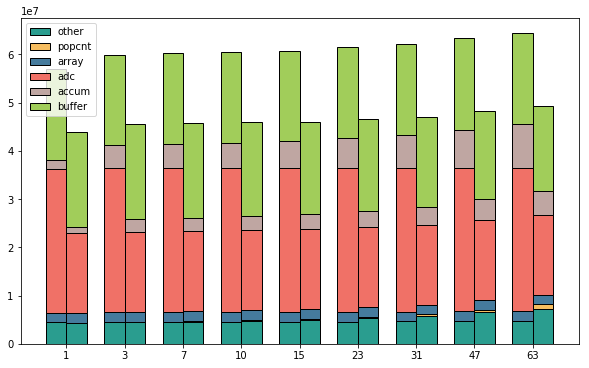

In [ ]:
bar_width = 0.35
index = np.arange(len(unique_TW))
# plot for column series
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(index, cifar10dvs_other_area_data_arr, bar_width, color=color_bar2[0], label="other", edgecolor='black')
bottom_arr = cifar10dvs_other_area_data_arr
plt.bar(index, cifar10dvs_popcnt_area_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[1], label="popcnt", edgecolor='black')
bottom_arr += cifar10dvs_popcnt_area_data_arr
plt.bar(index, cifar10dvs_array_area_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[2], label="array", edgecolor='black')
bottom_arr += cifar10dvs_array_area_data_arr
plt.bar(index, cifar10dvs_adc_area_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[3], label="adc", edgecolor='black')
bottom_arr += cifar10dvs_adc_area_data_arr
plt.bar(index, cifar10dvs_accum_area_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[4], label="accum", edgecolor='black')
bottom_arr += cifar10dvs_accum_area_data_arr
plt.bar(index, cifar10dvs_buffer_area_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[5], label="buffer", edgecolor='black')

# plot for array series
plt.bar(index + bar_width, cifar10dvs_other_area_data_col, bar_width, color=color_bar2[0], edgecolor='black')
bottom_col = cifar10dvs_other_area_data_col
plt.bar(index + bar_width, cifar10dvs_popcnt_area_data_col, bar_width, bottom=bottom_col, color=color_bar2[1], edgecolor='black')
bottom_col += cifar10dvs_popcnt_area_data_col
plt.bar(index + bar_width, cifar10dvs_array_area_data_col, bar_width, bottom=bottom_col, color=color_bar2[2], edgecolor='black')
bottom_col += cifar10dvs_array_area_data_col
plt.bar(index + bar_width, cifar10dvs_adc_area_data_col, bar_width, bottom=bottom_col, color=color_bar2[3], edgecolor='black')
bottom_col += cifar10dvs_adc_area_data_col
plt.bar(index + bar_width, cifar10dvs_accum_area_data_col, bar_width, bottom=bottom_col, color=color_bar2[4], edgecolor='black')
bottom_col += cifar10dvs_accum_area_data_col
plt.bar(index + bar_width, cifar10dvs_buffer_area_data_col, bar_width, bottom=bottom_col, color=color_bar2[5], edgecolor='black')

plt.xticks(index + bar_width / 2, unique_TW)
plt.legend(loc="upper left")

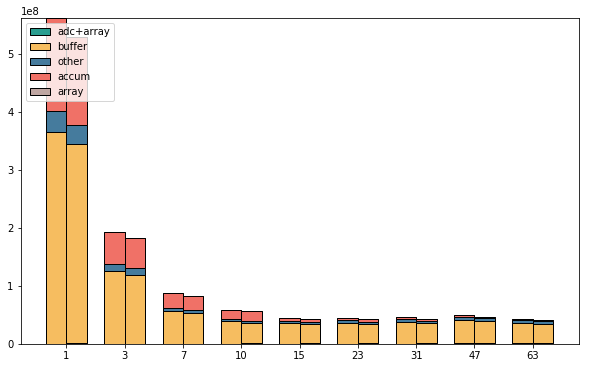

In [ ]:
bar_width = 0.35
index = np.arange(len(unique_TW))
# plot for column series
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(index, cifar10dvs_adc_latency_data_arr, bar_width, color=color_bar2[0], label="adc+array", edgecolor='black')
bottom_arr = cifar10dvs_adc_latency_data_arr
plt.bar(index, cifar10dvs_buffer_latency_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[1], label="buffer", edgecolor='black')
bottom_arr += cifar10dvs_buffer_latency_data_arr
plt.bar(index, cifar10dvs_other_latency_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[2], label="other", edgecolor='black')
bottom_arr += cifar10dvs_other_latency_data_arr
plt.bar(index, cifar10dvs_accum_latency_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[3], label="accum", edgecolor='black')
bottom_arr += cifar10dvs_accum_latency_data_arr
plt.bar(index, cifar10dvs_array_latency_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[4], label="array", edgecolor='black')

# plot for array series
plt.bar(index + bar_width, cifar10dvs_adc_latency_data_col, bar_width, color=color_bar2[0], edgecolor='black')
bottom_col = cifar10dvs_adc_latency_data_col
plt.bar(index + bar_width, cifar10dvs_buffer_latency_data_col, bar_width, bottom=bottom_col, color=color_bar2[1], edgecolor='black')
bottom_col += cifar10dvs_buffer_latency_data_col
plt.bar(index + bar_width, cifar10dvs_other_latency_data_col, bar_width, bottom=bottom_col, color=color_bar2[2], edgecolor='black')
bottom_col += cifar10dvs_other_latency_data_col
plt.bar(index + bar_width, cifar10dvs_accum_latency_data_col, bar_width, bottom=bottom_col, color=color_bar2[3], edgecolor='black')
bottom_col += cifar10dvs_accum_latency_data_col
plt.bar(index + bar_width, cifar10dvs_array_latency_data_col, bar_width, bottom=bottom_col, color=color_bar2[4], edgecolor='black')

plt.xticks(index + bar_width / 2, unique_TW)
plt.legend(loc="upper left")

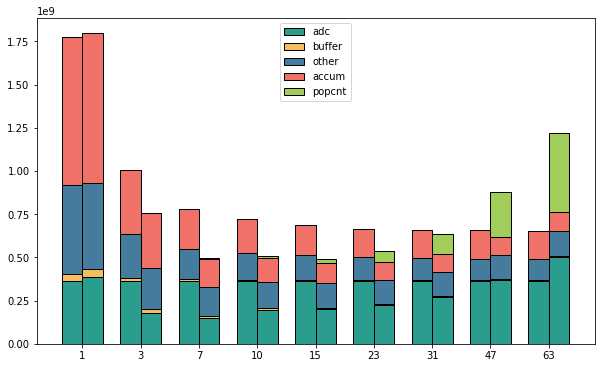

In [ ]:
bar_width = 0.35
index = np.arange(len(unique_TW))
# plot for column series
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(index, cifar10dvs_adc_energy_data_arr, bar_width, color=color_bar2[0], label="adc", edgecolor='black')
bottom_arr = cifar10dvs_adc_energy_data_arr
plt.bar(index, cifar10dvs_buffer_energy_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[1], label="buffer", edgecolor='black')
bottom_arr += cifar10dvs_buffer_energy_data_arr
plt.bar(index, cifar10dvs_other_energy_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[2], label="other", edgecolor='black')
bottom_arr += cifar10dvs_other_energy_data_arr
plt.bar(index, cifar10dvs_accum_energy_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[3], label="accum", edgecolor='black')
bottom_arr += cifar10dvs_accum_energy_data_arr
plt.bar(index, cifar10dvs_popcnt_energy_data_arr, bar_width, bottom=bottom_arr, color=color_bar2[5], label="popcnt", edgecolor='black')

# plot for array series
plt.bar(index + bar_width, cifar10dvs_adc_energy_data_col, bar_width, color=color_bar2[0], edgecolor='black')
bottom_col = cifar10dvs_adc_energy_data_col
plt.bar(index + bar_width, cifar10dvs_buffer_energy_data_col, bar_width, bottom=bottom_col, color=color_bar2[1], edgecolor='black')
bottom_col += cifar10dvs_buffer_energy_data_col
plt.bar(index + bar_width, cifar10dvs_other_energy_data_col, bar_width, bottom=bottom_col, color=color_bar2[2], edgecolor='black')
bottom_col += cifar10dvs_other_energy_data_col
plt.bar(index + bar_width, cifar10dvs_accum_energy_data_col, bar_width, bottom=bottom_col, color=color_bar2[3], edgecolor='black')
bottom_col += cifar10dvs_accum_energy_data_col
plt.bar(index + bar_width, cifar10dvs_popcnt_energy_data_col, bar_width, bottom=bottom_col, color=color_bar2[5], edgecolor='black')

plt.xticks(index + bar_width / 2, unique_TW)
plt.legend(loc="upper center")


## 分析单文件Layer和TS性能

In [ ]:
import re
import pandas as pd
import numpy as np
import sys
import json
import matplotlib.pyplot as plt

In [ ]:
fname = "..\PyNeuroSimLog\PyNeuroSim_3_DVS128Gesture_array.err"

_, tw, dataset, mode = fname.split('\\')[-1].split('.')[0].split('_')
print(tw, dataset, mode)

pat = re.compile(r'TS (\d+) layer (\d+) ([a-zA-Z]*)[:=\s]+(\d+\.\d+e?\+?\d.?)|([a-zA-Z()]+) of layer (\d+) = (\d+\.\d+e?\+?\d.?)')
with open(fname, 'r') as fr:
    contents = fr.read()
    res = re.findall(pat, contents)
    print(len(res))

res_dict = {}
if dataset not in res_dict:
    res_dict[dataset] = {}
    if tw not in res_dict[dataset]:
        res_dict[dataset][tw] = {}
        if mode not in res_dict[dataset][tw]:
            res_dict[dataset][tw][mode] = {}
            for item in res:
                if item[3] == '':  # key, layer, val
                    key, layer, val = item[-3:]
                    if layer not in res_dict[dataset][tw][mode]:
                        res_dict[dataset][tw][mode][layer] = {}
                        if key not in res_dict[dataset][tw][mode][layer]:
                            res_dict[dataset][tw][mode][layer][key] = [float(val)]
                        else:
                            res_dict[dataset][tw][mode][layer][key].append(float(val))
                    else:
                        if key not in res_dict[dataset][tw][mode][layer]:
                            res_dict[dataset][tw][mode][layer][key] = [float(val)]
                        else:
                            res_dict[dataset][tw][mode][layer][key].append(float(val))
                elif item[4] == '': # ts, layer, key, val
                    ts, layer, key, val = item[:4]
                    # ignore ts here, because list is ordered by ts
                    if layer not in res_dict[dataset][tw][mode]:
                        res_dict[dataset][tw][mode][layer] = {}
                        if key not in res_dict[dataset][tw][mode][layer]:
                            res_dict[dataset][tw][mode][layer][key] = [float(val)]
                        else:
                            res_dict[dataset][tw][mode][layer][key].append(float(val))
                    else:
                        if key not in res_dict[dataset][tw][mode][layer]:
                            res_dict[dataset][tw][mode][layer][key] = [float(val)]
                        else:
                            res_dict[dataset][tw][mode][layer][key].append(float(val))


1 DVS128Gesture array
44100


In [ ]:
# save res_dict to a json file
import json
with open('res_dict.json', 'w') as fw:
	json.dump(res_dict, fw, indent=4)

In [ ]:
# 可视化每一层的数据
unique_layers = list(res_dict[dataset][tw][mode].keys())
unique_keys = res_dict[dataset][tw][mode][unique_layers[0]].keys()
print(unique_layers, '\n', unique_keys)


['1', '2', '3', '4', '5', '6', '7'] 
 dict_keys(['readLatency', 'bufferLatency', 'icLatency', 'coreLatencyADC', 'coreLatencyAccum', 'coreLatencyOther', 'readDynamicEnergy', 'leakagePower', 'leakageEnergy', 'bufferDynamicEnergy', 'icDynamicEnergy', 'coreEnergyADC', 'coreEnergyAccum', 'coreEnergyOther', 'coreEnergyPopcnt', 'Average(denseRatio)', 'Max(denseRatio)', 'Min(denseRatio)', 'Average(recoverFactor)', 'Max(recoverFactor)', 'Min(recoverFactor)'])


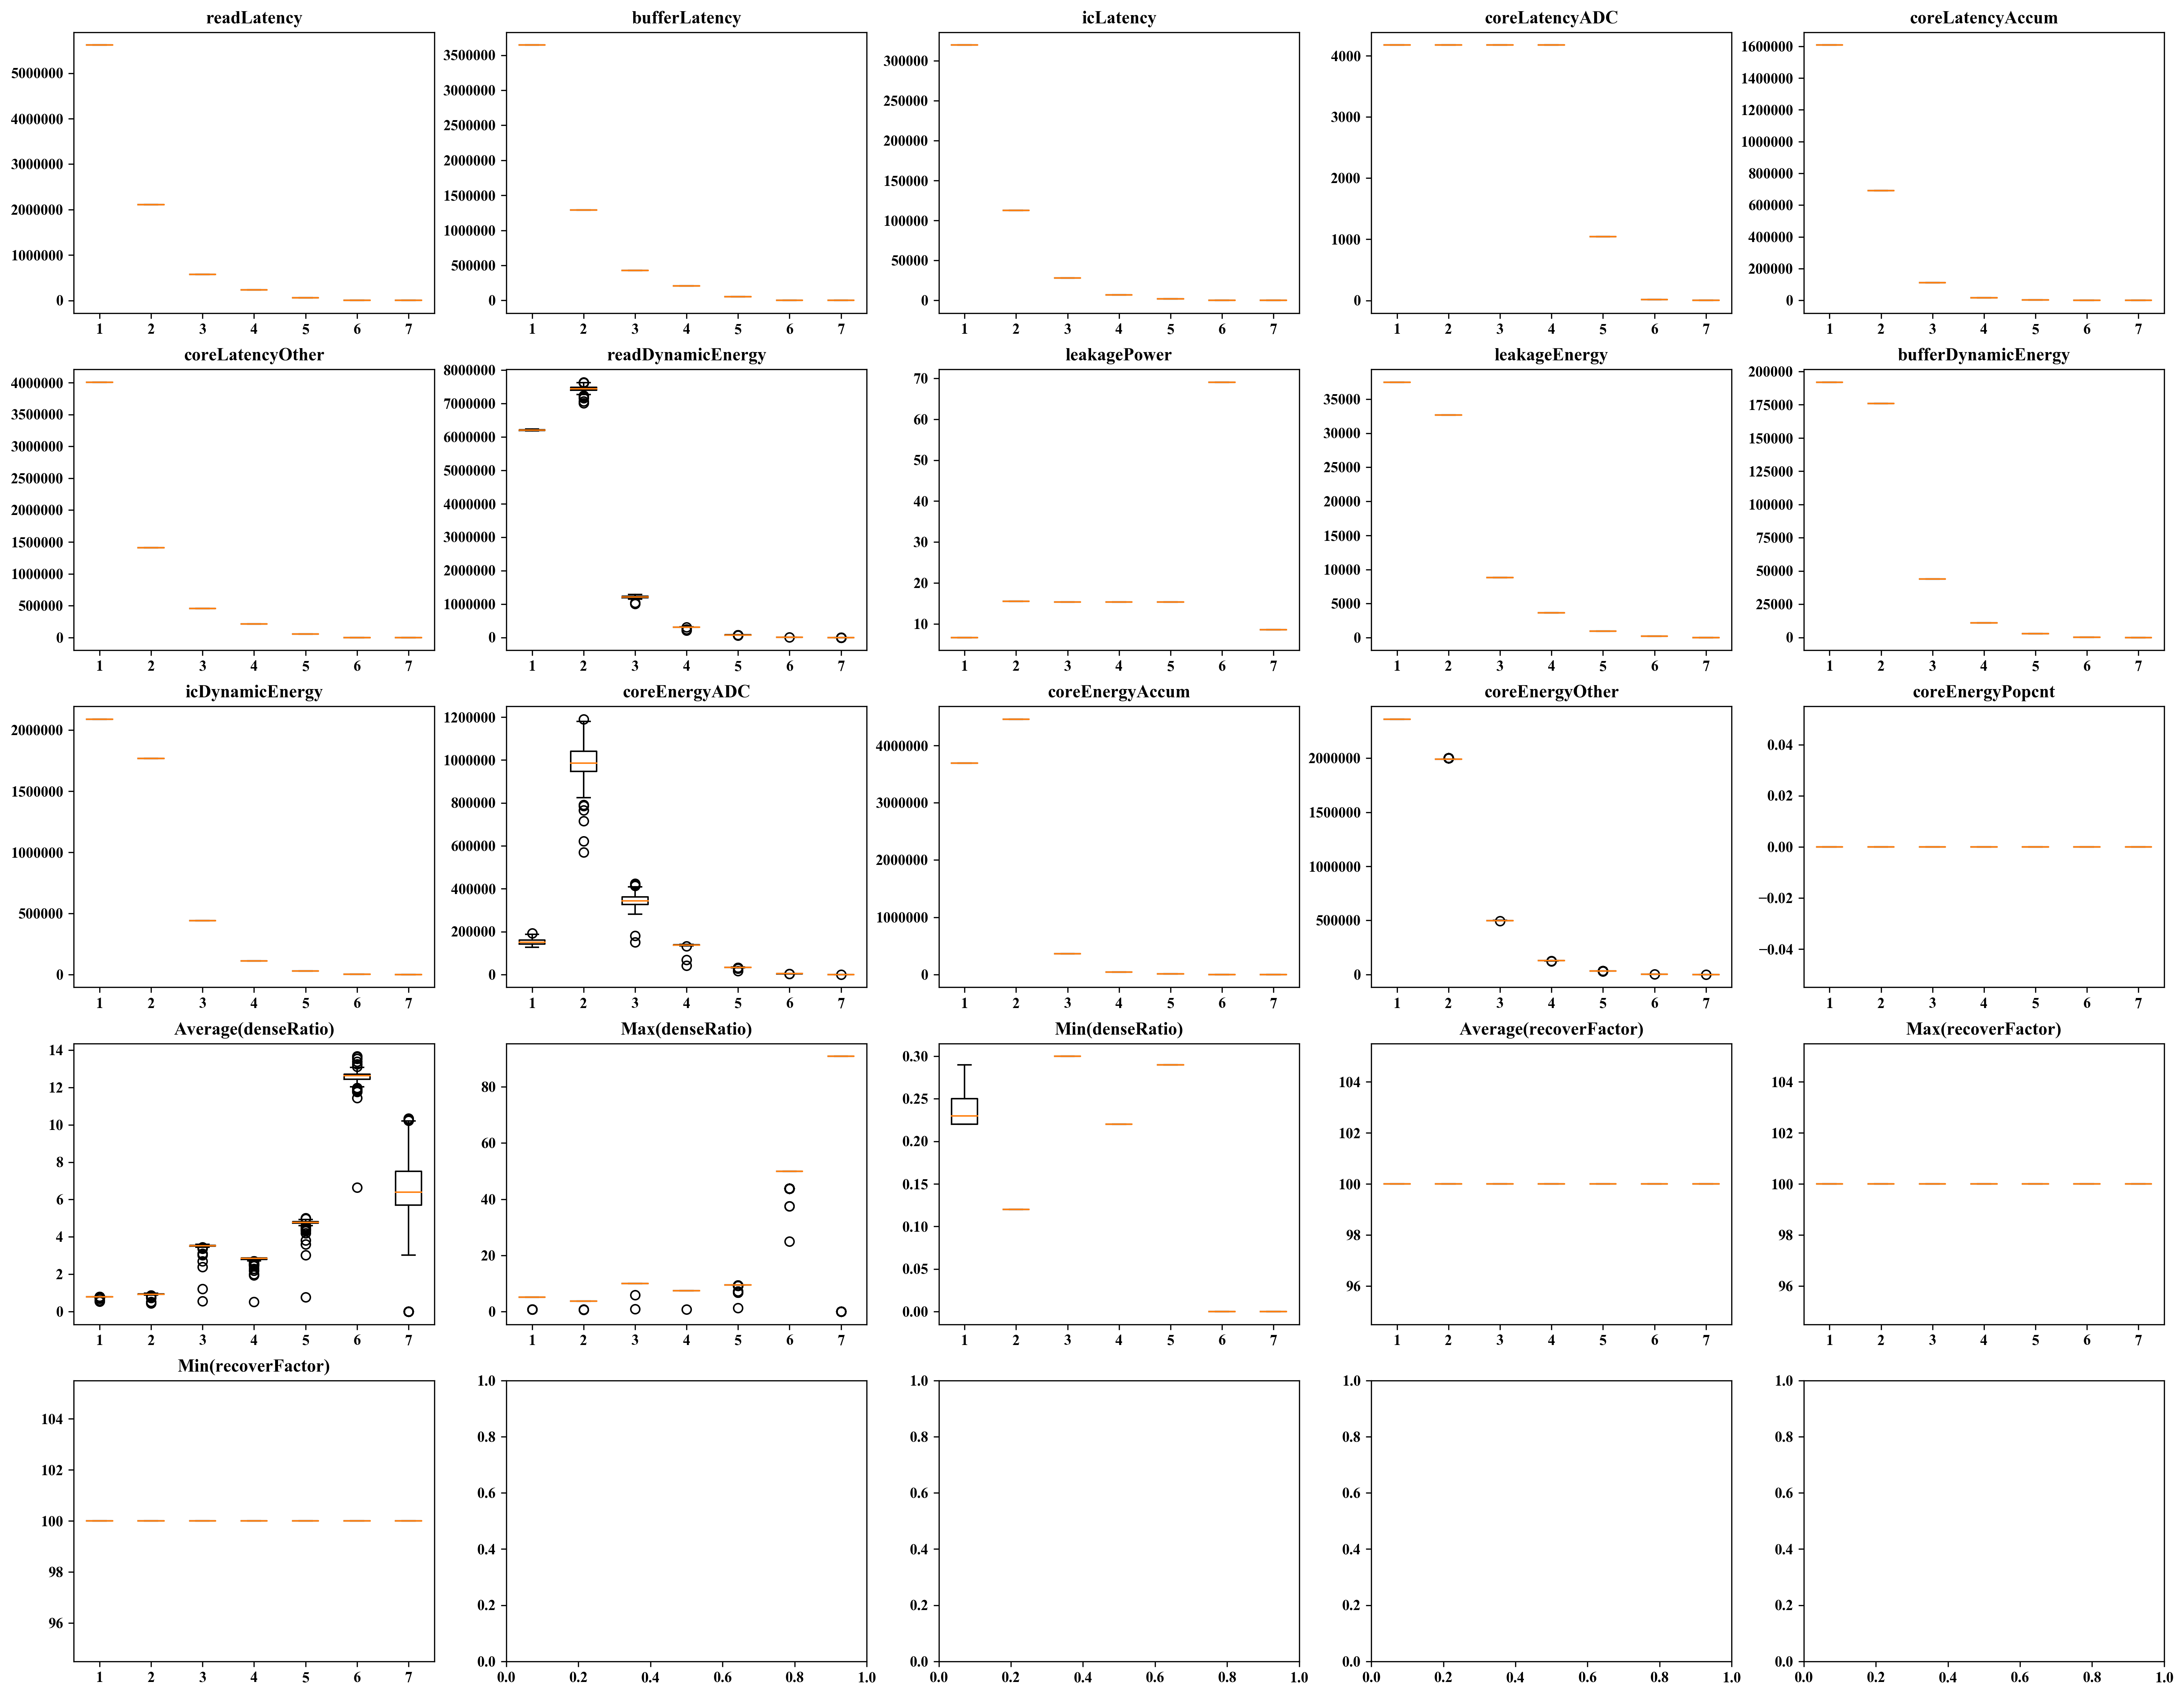

In [ ]:
frow = math.ceil(math.sqrt(len(unique_keys)))
fcol = math.ceil(len(unique_keys) / frow)

# Create a grid of subplots.
fig, axs = plt.subplots(frow, fcol, figsize=(25, 20), dpi=300)

# Flatten the axs array for easy indexing, in case of a 2D configuration.
axs = axs.flatten()

for idx, key in enumerate(unique_keys):
    # Select the appropriate subplot.
    ax = axs[idx]
    
    # Prepare the data for the boxplot.
    data = [res_dict[dataset][tw][mode][layer][key] for layer in unique_layers]
    
    # Plot the boxplot on the selected subplot.
    ax.boxplot(data, labels=unique_layers)
    ax.set_title(key)  # Optionally set a title for each subplot to identify the key.